In [1]:
def run_generate_data():
    from data_generator import generate_data
    generate_data()
# run_generate_data()

# 加载数据

In [2]:
from data_generator import *
data_set = generate_data(recreate=False)

# Transform
data_set.train.trans()
data_set.validation.trans()

train_data = data_set.train
validate_data = data_set.validation
X_train, y_train = data_set.train.images, data_set.train.labels
X_train = X_train.reshape([len(X_train), 30, 30, 1])
X_validate, y_validate = data_set.validation.images, data_set.validation.labels
X_validate = X_validate.reshape([len(X_validate), 30, 30, 1])
print('*' * 10, ' Train Set ', '*' * 10)
print('Count       : ', train_data.num_examples)
print('Images Shape: ', train_data.images.shape)
print('Labels Shape: ', train_data.labels.shape)
print()

print('*' * 10, ' Validate Set ', '*' * 10)
print('Count       : ', validate_data.num_examples)
print('Images Shape: ', validate_data.images.shape)
print('Labels Shape: ', validate_data.labels.shape)

**********  Train Set  **********
Count       :  90000
Images Shape:  (90000, 900)
Labels Shape:  (90000,)

**********  Validate Set  **********
Count       :  30000
Images Shape:  (30000, 900)
Labels Shape:  (30000,)


# 显示图片

1


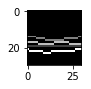

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
img = X_train[0].reshape([30, 30])

plt.figure(figsize=(1,1))
plt.imshow(img, cmap="gray")
print(y_train[0])

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

/home/bovenson/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

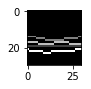

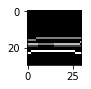

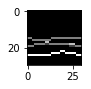

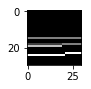

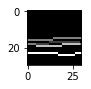

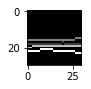

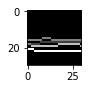

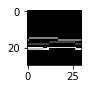

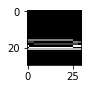

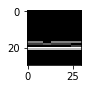

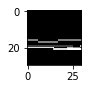

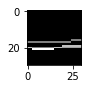

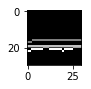

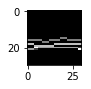

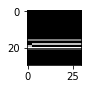

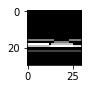

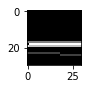

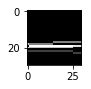

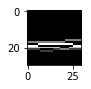

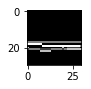

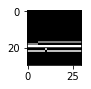

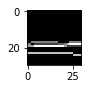

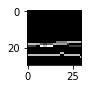

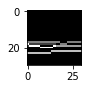

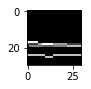

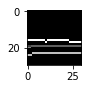

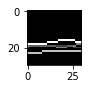

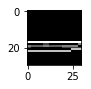

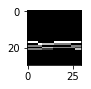

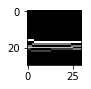

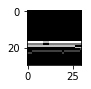

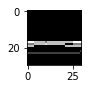

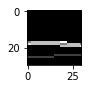

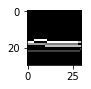

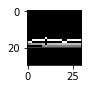

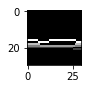

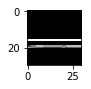

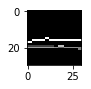

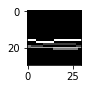

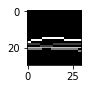

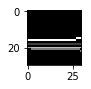

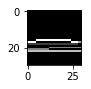

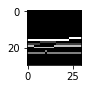

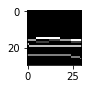

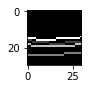

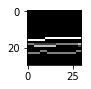

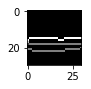

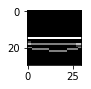

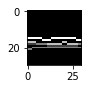

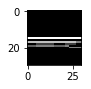

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

s = set()
for i in range(len(X_train)):
    if y_train[i] in s:
        continue
    img = X_train[i].reshape([30, 30])
    plt.figure(figsize=(1,1))
    plt.imshow(img, cmap="gray")
    plt.imsave(str(y_train[i]) + '.png', img, cmap='gray')
    
    print(y_train[i], end=' ')
    s.add(y_train[i])

In [4]:
from math import sqrt

def put_kernels_on_grid (kernel, pad = 1):
      '''Visualize conv. filters as an image (mostly for the 1st layer).
      Arranges filters into a grid, with some paddings between adjacent filters.
      Args:
        kernel:            tensor of shape [Y, X, NumChannels, NumKernels]
        pad:               number of black pixels around each filter (between them)
      Return:
        Tensor of shape [1, (Y+2*pad)*grid_Y, (X+2*pad)*grid_X, NumChannels].
      '''
      # get shape of the grid. NumKernels == grid_Y * grid_X
      def factorization(n):
        for i in range(int(sqrt(float(n))), 0, -1):
          if n % i == 0:
            if i == 1: print('Who would enter a prime number of filters')
            return (i, int(n / i))
      (grid_Y, grid_X) = factorization (kernel.get_shape()[3].value)
      print ('grid: %d = (%d, %d)' % (kernel.get_shape()[3].value, grid_Y, grid_X))

      x_min = tf.reduce_min(kernel)
      x_max = tf.reduce_max(kernel)
      kernel = (kernel - x_min) / (x_max - x_min)

      # pad X and Y
      x = tf.pad(kernel, tf.constant( [[pad,pad],[pad, pad],[0,0],[0,0]] ), mode = 'CONSTANT')

      # X and Y dimensions, w.r.t. padding
      Y = kernel.get_shape()[0] + 2 * pad
      X = kernel.get_shape()[1] + 2 * pad

      channels = kernel.get_shape()[2]

      # put NumKernels to the 1st dimension
      x = tf.transpose(x, (3, 0, 1, 2))
      # organize grid on Y axis
      x = tf.reshape(x, tf.stack([grid_X, Y * grid_Y, X, channels]))

      # switch X and Y axes
      x = tf.transpose(x, (0, 2, 1, 3))
      # organize grid on X axis
      x = tf.reshape(x, tf.stack([1, X * grid_X, Y * grid_Y, channels]))

      # back to normal order (not combining with the next step for clarity)
      x = tf.transpose(x, (2, 1, 3, 0))

      # to tf.image_summary order [batch_size, height, width, channels],
      #   where in this case batch_size == 1
      x = tf.transpose(x, (3, 0, 1, 2))

      # scaling to [0, 255] is not necessary for tensorboard
      return x


#
# ... and somewhere inside "def train():" after calling "inference()"
#

# Visualize conv1 kernels
# with tf.variable_scope('conv1'):
#       tf.get_variable_scope().reuse_variables()
#       weights = tf.get_variable('weights')
#       grid = put_kernels_on_grid (weights)
#       tf.image.summary('conv1/kernels', grid, max_outputs=1)

# Setup Tensorflow

In [5]:
import tensorflow as tf

EPOCHS = 1
BATCH_SIZE = 50

/home/bovenson/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 输入
LeNet接受`32*32*color_channels`作为输入。

# 结构
- 第一层
    - 卷积层: 
        - 卷积核尺寸: 3
        - 深度     : 6
        - 步长     : 1
        - 全零填充
        - 输出     : `30*30*6`
    - 激活函数: ReLu
    - 池化层: 
        - 过滤器尺寸: 2
        - 步长     : 2
        - 输出     : `15*15*6`
- 第二层
    - 卷积层
        - 输入     : `15*15*6`
        - 深度     : 16
        - 步长     : 1
        - 卷积核尺寸: 3
        - 输出     : `15*15*16`
    - 激活函数: ReLu
    - 池化层: 
        - 过滤器尺寸: 3
        - 步长     : 3
        - 输出     : `5*5*16`
    - Flatten: Flatten the output shape of the final pooling layer such that it's 1D instead of 3D
- 第三层
    - 全连接层: 120个神经元
    - 激活函数: ReLu
- 第四层
    - 全连接层: 84个神经元
    - 激活函数: ReLu
- 第五层
    - 全连接层(Logits): 50个神经元

In [6]:
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, stride=1, padding='SAME'):
    """
    实现纳卷积操作
    x: 输入
    W: 卷积核
    b: 偏置
    strides: 步长
    padding: padding
    """
    x = tf.nn.conv2d(input=x, filter=W, strides=[1, stride, stride, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2, padding='SAME'):
    """
    池化操作
    x: 输入
    k: 步长及过滤器尺寸
    padding: padding
    """
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)


def fc_relu(x, W, b):
    """
    全连接层激活函数
    x: 输入
    W: 卷积核
    b: 偏置
    """
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)


def LeNet(x):
    """定义LeNet"""
    # 定义参数
    mu = 0
    sigma = 0.1
    weights = {
        # 第一层; 卷积操作卷积核
        'wc1': tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 6), mean = mu, stddev = sigma, name='wc1')), 
        # 第三层; 卷积操作卷积核
        'wc2': tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma, name='wc2')), 
        # 第五层; 全连接操作
        'wfc': tf.Variable(tf.truncated_normal(shape=(5*5*16, 120), mean = mu, stddev = sigma, name='wfc')), 
        # 输出层; 全连接操作
        'out': tf.Variable(tf.truncated_normal(shape=(120, 50), mean = mu, stddev = sigma, name='wout')),
    }
    biases = {
        # 第一层
        'bc1': tf.Variable(tf.zeros(6)),
        # 第三层
        'bc2': tf.Variable(tf.zeros(16)),
        # 第五层
        'bfc': tf.Variable(tf.zeros(120)),
        # 输出层
        'out': tf.Variable(tf.zeros(50))
    }
    
    # 第一层
    ## 卷积操作
    ### 输入 = 30*30*1
    ### 输出 = 30*30*6
    ## 激活操作
    ## 池化操作
    ### 输入 = 30*30*6
    ### 输出 = 15*15*6
    c1 = conv2d(x, weights['wc1'], biases['bc1'])
    tf.summary.image('conv1_features', tf.split(c1, num_or_size_splits=6, axis=3)[0], 10)
    c1 = maxpool2d(c1, k=2)

    # 第二层
    ## 卷积操作
    ### 输入 = 15*15*6
    ### 输出 = 15*15*16
    ## 激活操作
    ## 池化操作
    ### 输入 = 15*15*6
    ### 输出 = 5*5*6
    c2 = conv2d(c1, weights['wc2'], biases['bc2'])
    c2 = maxpool2d(c2, k=3)
    
    # Flatten
    ## input 5*5*16
    ## output 400
    c2_flat = flatten(c2)
    
    # 第三层
    ## Fully Connected
    ## Input = 400
    ## Output = 120
    # Activation
    fc = fc_relu(c2_flat, weights['wfc'], biases['bfc']) 
    
    # Layer 第五层
    ## 输出层
    ## Fully Connected
    ## Input = 120
    ## Output = 50
    logits = tf.add(tf.matmul(fc, weights['out']), biases['out'])
    return logits

Instructions for updating:
Use the retry module or similar alternatives.


# 特征和标签
- x is a placeholder for a batch of input images
- y is a placeholder for a batch of output labels

In [7]:
x = tf.placeholder(tf.float32, (None, 30, 30, 1), name='x-input')
y = tf.placeholder(tf.int32, (None), name='y-input')
one_hot_y = tf.one_hot(y, 50)

# Training Pipeline

In [8]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# 模型验证

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# 训练模型

In [10]:
from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('log', sess.graph)
    num_examples = train_data.num_examples
    
    # with tf.variable_scope('conv1'):
        # tf.get_variable_scope().reuse_variables()

    
    print('Training...\n')
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            # print(batch_x.shape)
            # print(batch_y.shape)
            # batch_x = batch_x.reshape([len(batch_x), 30, 30, 1])
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        validation_accuracy = evaluate(X_validate, y_validate)
        print('EPOCHS {} ...'.format(i))
        print('Validation Accuracy = {:.3f}'.format(validation_accuracy))
        print()
        
    saver.save(sess, './model')
    print("Model saved")

Training...

EPOCHS 0 ...
Validation Accuracy = 0.235

Model saved
